# Tarea 0
# INF477 Redes Neuronales Artificiales I-2018

Profesor: Dr. Ricardo Ñanculef -- 
Ayudante: Francisco Mena

Alumna: Eliana Providel Godoy, eprovide@inf.utfsm.cl

# 1) Back-propagation from Scratch

** Antes de desarrollar cada ítem de la tarea, se definen las funciones a utilizar - de activación y costo **

In [1]:
import numpy as np
#np.random.seed(0)


In [2]:
## Sigmoid y su derivada

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def d_sigmoid(x):
    return sigmoid(x) * (1 - sigmoid(x))
    

In [3]:
## Softmax y su derivada

def softmax(x):
    e_x = np.exp(x - np.max(x))
    return e_x / e_x.sum(axis=0)

def d_softmax(x):
    return x * (1 - x)

In [4]:
## Softmax y su derivada

def relu(x):
    return np.maximum(0,x)

def d_relu(x):
    if x <= 0:
        return 0
    else:
        return 1

In [5]:
# Error cuadrático medio y su derivada

def loss_mse(_yexp, _ypred):
    return (1/2) * np.square(_yexp - _ypred).mean()

def d_loss_mse(_yexp, _ypred):
    m = len(_yexp)
    return (_ypred - _yexp) / m

In [6]:
# Cross-Entropy y su derivada

def loss_ce(_yexp,_ypred):
    err = 0
    for i in range(0, len(_ypred)):
        err += _yexp[i] * np.log(_ypred[i])
    return -err

def d_loss_ce(_yexp, _ypred):
    res = [0] * len(_ypred)
    for i in range(0, len(_ypred)):
        res[i] = (- _yexp[i]/_ypred[i]) + ((1 - _yexp[i]) / (1 - _ypred[i]))
    
    res = np.nan_to_num(res)
    #print("dce yexp:\n%s" % _yexp)
    #print("dce ypred:\n%s" % _ypred)
    #print("dce err res:\n%s" % res)
    
    return res

** Datos de configuración: número de neuronas por capa y número de epochs **

In [7]:
## Configuración de número de neuronas de cada capa
SL1 = 4
SL2 = 32
SL3 = 16
SL4 = 3

EPOCHS = 100
EPOCHS_KERAS = 100

## Por simplicidad no se utilizo sesgos.

## a)  Entrenar red FF

### i) Implementación Forward Pass

In [8]:
## Recibe como parámetro los atributos de entrada (X), los pesos (_W_k), 
## la función de activación para las capas ocultas (_act) 
## y para la capa de salida (_actout)

##  Los resultados de la pre activación se almacenaran en z_k y 
##  los resultados de la activación en a_k, que son los valores de retorno.
def forwardpass(x, _W1, _W2, _W3, _act, _actout):
    a_1 = x
    z_2 = np.dot(_W1, a_1)
    a_2 = _act(z_2)    
    
    z_3 = np.dot(_W2, a_2)
    a_3 = _act(z_3)

    z_4 = np.dot(_W3, a_3)
    a_4 = _actout(z_4)    

    return a_4, z_4, a_3, z_3, a_2, z_2, a_1

### ii) Implementación de backward pass

In [9]:
## Recibe como parámetro los resultados esperados (_yexp), los resultados predecidos (_ypred),
## la función de perdida y su derivada (_loss, _dloss), la derivada de la función de activación
## para las capas ocultas (_d_act) y para la capa de salida (_d_act_out),
## los resultados de la preactivación (_z_k) y de activación (_a_z), los pesos (_W_k)
## y número de neuronas por cada (_sLk)

## Retorna los gradientes de los pesos de cada capa:
## los gradientes delta_W3, delta_W2, delta_W1.  

## se adapto la versión iterativa de backpropagation que se explica en: http://ufldl.stanford.edu/wiki/index.php/Backpropagation_Algorithm

def backwardpass(
    _yexp, _ypred,
    _loss, _d_loss, _d_act, _d_act_out,
    _a_4, _z_4, _a_3, _z_3, _a_2, _z_2, _a_1,    
    _W1, _W2, _W3,
    _sL1, _sL2, _sL3, _sL4):    
    
    ###################
    ## Los delta L4 son el error entre los valores predecidos y los esperados,
    ## y se usan para calcular los delta de la matriz de peso _W3, que corresponde a la 
    ## segunda capa oculta.
    ## Los delta L3 y L2 representan la propagación del error hacia la capa interna y se usan para calcular
    ## para calcular las matrices de peso de _W2 y _W1. Cada delta_Wk corresponde a las derivadas parciales respecto
    ## de los pesos de la capa k.
    
    ## Se considero por separado la derivada de la función de costo y de la activación de salida
    ## a diferencia de tutoriales que usaban una simplificación analítica especifica en las combinaciones
    ## utilizadas.
    
    ###################
    ## deltas L4
    error = _loss(_yexp, _ypred)
    
    deltas_L4 = [0] * _sL4
    for i in range(0, _sL4):       
        deltas_L4[i] = _d_loss(_yexp, _ypred)[i]
    
    ### delta_W3    
    delta_W3 = np.zeros(_W3.shape)
    for i in range(0, _sL4):
        for j in range(0, _sL3):            
            delta_W3[i,j] = _a_3[j] * deltas_L4[i] * _d_act_out(_a_4[i])
    
    ###################
    ### deltas L3
    deltas_L3 = [0] * _sL3
    for i in range(0, _sL3):
        deltas_L3[i] = 0        
        for j in range(0, _sL4):
            deltas_L3[i] += (_W3[j,i] * deltas_L4[j])            
        deltas_L3[i] = deltas_L3[i] * _d_act(_z_3[i])

    ### delta_W2
    delta_W2 = np.zeros(_W2.shape)
    for i in range(0, _sL3):
        for j in range(0, _sL2):
            delta_W2[i,j] = _a_2[j] * deltas_L3[i]
     
    ###################
    ### deltas L2
    deltas_L2 = [0] * _sL2
    for i in range(0, _sL2):
        deltas_L2[i] = 0        
        for j in range(0, _sL3):
            deltas_L2[i] += (_W2[j,i] * deltas_L3[j])            
        deltas_L2[i] = deltas_L2[i] * _d_act(_z_2[i])

    ### delta_W1
    delta_W1 = np.zeros(_W1.shape)
    for i in range(0, _sL2):
        for j in range(0, _sL1):
            delta_W1[i,j] = _a_1[j] * deltas_L2[i]            
            
    return delta_W1, delta_W2, delta_W3

### iii) Función para entrenar

In [10]:
import random
from itertools import cycle ## permite hacer una lista ciclica para los datos de entrenamiento.

## Recibe como parámetro el conjunto de entrenamiento (_X_train, _y_train), 
## la función de costo (_loss) y su derivada (_d_loss), el número de neuronas para cada capa k (_sLk),
## la función de activación para las capas ocultas (_act) y para la capa de salida (_act_out),
## y sus derivadas (_d_act, _d_act_out),
## el número de epochs, la configuración de verbose (por defecto desactivado),
## y la tasa de entrenamiento, por defecto 0.1

## La función  entrena utilizando la variante aleatoria de SGD de acuerdo al enunciado, tomando los ejemplos
## de uno en uno, desde una lista ciclica aleatorizada de los datos de entrenamiento.
## Es importante mencionar que los pesos iniciales son determinados aleatoriamente según la función np.random.random().
## Si bien, esto es mejor que inicializar todos los pesos en un mismo valor constante, el desempeño del entrenamiento 
## se ve ciertamente afectado por los valores iniciales, es decir, distintas ejecuciones  pueden variar muy grandemente
## en la precisión de la red ya entrenada.


def train(
    _X_train, _y_train,
    _loss, _d_loss,
    _sL1, _sL2, _sL3, _sL4,
    _act, _act_out, _d_act, _d_act_out,
    _epochs,
    _verbose = False,
    _LR = 0.1):
    
    ## Inicialización de los pesos co valores aleatorios, se le suma 0.01 para evitar pesos con valor = 0 
    _W1 = np.random.random((_sL1, _sL2)).T + 0.01
    _W2 = np.random.random((_sL2, _sL3)).T + 0.01
    _W3 = np.random.random((_sL3, _sL4)).T + 0.01
    
    ## Construye la lista aleatorizada y ciclica de los datos de entrenamiento 
    train_data = list(zip(_X_train, _y_train))
    random.shuffle(train_data)
    train_data = cycle(train_data)
    
    ## Listas para almacenar información de la función objetivo, y los valores intermedios del entrenamiento
    ## para graficar el error de precisión.
    loss_data  = []
    epoch_data = []
    print("LR: %s" % _LR)
    print("Epochs: %s" % _epochs)
    
    ## Repetición de cantidad fija de epochs
    for e in range(_epochs):
        ## almacena pesos del epoch actual para grafico de precisión
        epoch_data.append((_W1, _W2, _W3)) 
        
        ## Se escoge el siguiente ejemplo y su valor estimado
        x_example, y_example = next(train_data)
        
        ## Se ejecuta fordward pass para el ejemplo seleccionado. 
        ## Retorna los valores de pre activación y activación
        a_4, z_4, a_3, z_3, a_2, z_2, a_1 = forwardpass(x_example,
                                                        _W1, _W2, _W3,                                                       
                                                        _act, _act_out)
        
        ## Corresponde al valor de la predicción
        y_pred = a_4        
        
        ## Calcula el costo  o error de predicción
        loss = _loss(y_example, y_pred)        
        if(_verbose): #and e % 100 ==0):
            print("Epoch %s" % e)
            print("Loss: %s" % loss)
        
        ## Se almacena el costo para gráfico de función objetivo
        loss_data.append(loss.item())   
        
        ## Ejecuta el backward pass para obtener los ajustes de los pesos.
        delta_W1, delta_W2, delta_W3 = backwardpass(y_example,        
                                          y_pred,
                                          _loss, _d_loss, _d_act, _d_act_out,
                                          a_4, z_4, a_3, z_3, a_2, z_2, a_1,                                          
                                          _W1, _W2, _W3,                                          
                                          _sL1, _sL2, _sL3, _sL4)
        
        ## Ajuste de los pesos
        _W1 = _W1 - _LR * delta_W1
        _W2 = _W2 - _LR * delta_W2
        _W3 = _W3 - _LR * delta_W3
        
    return _W1, _W2, _W3, (range(_epochs), loss_data, epoch_data)

## b) Predicciones mediante FF

In [11]:
## Retorna el  índice del valor máximo del vector de entrada x.
## Esto corresponde a la clase predecida, ya que se sabe que x fue calculado con softmax
## y por tanto los valores representan la probabilidad de que el elemento pertenezca a la clase.
## Entonces la clase predicha es la del índice con el mayor valor.
def decidir(x):
    return np.argmax(x)


## Aplica la decisión  sobre el resultado del forward pass vectorial, fila por fila.
def decidir_vec(X):
    return np.apply_along_axis(decidir, 1, X)

### Forward pass vectorial 

In [12]:
## Versión vectorizada de forward pass, donde X representa varios datos de entrada, uno por cada fila.
## Al igual que forward pass retorna los valores de preactivación (Z_k) y de activación (A_k) que son matrices.

def forwardpass_vec(X, _W1, _W2, _W3, _act, _actout):
    A_1 = X
    Z_2 = np.dot(A_1, _W1.T)
    A_2 = _act(Z_2)
    
    Z_3 = np.dot(A_2, _W2.T)
    A_3 = _act(Z_3)
    
    Z_4 = np.dot(A_3, _W3.T)
    A_4 = _actout(Z_4)

    return A_4, Z_4, A_3, Z_3, A_2, Z_2, A_1

## c) Clasificación con dataset Iris

In [13]:
## Configuración de datos de entrenamiento según el enunciado.
## Entrenar
import time
import matplotlib.pyplot as plt
%matplotlib inline
from keras.losses import categorical_crossentropy
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import load_iris
X_train,y_train = load_iris(return_X_y=True)
scaler = StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)
#transform target to one hot vector
import keras
y_onehot = keras.utils.to_categorical(y_train)

Using TensorFlow backend.


** Función para analizar los distintos casos ** 

In [14]:
## Calcula la precisión de las predicciones versus los datos esperados.
## Representa el promedio de valores correctamente predichos.

def precision(pred, exp):
    return np.mean(pred == exp)

In [15]:
from sklearn.metrics import confusion_matrix

## Función que permite ejecutar forward pass, obtener matriz de confusión (en caso de requerir) y gráficos
## Calcula tiempo de entrenamiento.
## La función se utiliza de acuerdo a la descripción de cada caso.

def analizarCaso(_X_train, _y_onehot,
                 _actfun , _d_actfun,
                 _actout , _d_actout,
                 _loss   , _d_loss  ,
                 _epochs = EPOCHS,
                 _LR = 0.1,
                 _verbose = False,
                 _training = train,
                 _confusion = False):
    
    T_start = time.time()
    
    ## Se recibe como parámetro la función _training para poder elegir entre el entrenamiento normal
    ## y la variante con momentum, ya que ambos reciben los mismos parámetros.
    TW1, TW2, TW3, loss_data = _training(
        _X_train, _y_onehot,
        _loss, _d_loss,
        SL1, SL2, SL3, SL4,
        _actfun, _actout, _d_actfun, _d_actout,
        _epochs,
        _verbose=_verbose,
        _LR = _LR)
    
    T_end = time.time()
    T_time = T_end - T_start
    print ("Tiempo de entrenamiento: %s (seg) " % T_time)    

    ## Calcular precision de la red ya entrenada
    YY, _, _, _, _, _, _ = forwardpass_vec(X_train, TW1, TW2, TW3, _actfun, softmax)
    
    ## Clasificacion segun la red entrenada
    DY = decidir_vec(YY)
    
    ## Precision: promedio de datos de entrenamiento clasificados correctamente
    print("Precision red entrenada: %s %%" % (precision(DY, y_train) * 100,))
    
    if(_confusion):
        cm = confusion_matrix(y_train, DY)
        print("Matriz de confusion:\n%s" % cm)
        
    ##################################################
    ### Gráfico Error de clasificacion vs numero de epochs
    misclassification = []
    for (EW1, EW2, EW3) in loss_data[2]:        
        YYY, _, _, _, _, _, _ = forwardpass_vec(X_train, EW1, EW2, EW3, _actfun, softmax)
        DYY = decidir_vec(YYY)
        misclassification.append(1 - precision(DYY, y_train))
    
    plt.plot(loss_data[0], misclassification)
    plt.ylim(ymin=0, ymax=1)
    plt.title("Error de clasificacion vs epochs")
    plt.show()
    
    ### Gráfico Evolución de la función objetivoloss vs epochs
    plt.plot(loss_data[0], loss_data[1])
    plt.ylim(ymin=0)
    plt.title("Funcion objetivo vs epochs")
    plt.show()

### Usando la función de entrenamiento

* Caso 1: Función de costo/perdida = MSE y activación = RELU
* Caso 2: Función de costo/perdida = MSE y activación = Sigmoid
* Caso 3: Función de costo/perdida = cross entropy y activación = RELU
* Caso 4: Función de costo/perdida = cross entropy y activación = Sigmoid  

**Caso 1: RELU y MSE**

LR: 0.1
Epochs: 100
Tiempo de entrenamiento: 0.30327391624450684 (seg) 
Precision red entrenada: 34.0 %


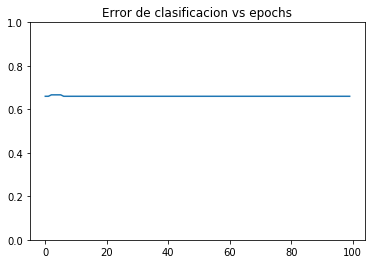

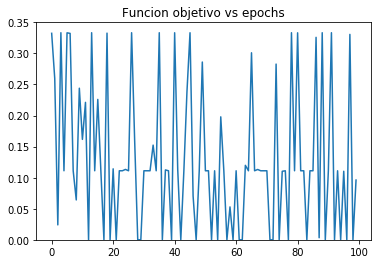

In [16]:
analizarCaso(X_train, y_onehot, relu, d_relu, softmax, d_softmax, loss_mse, d_loss_mse)

**Análisis**: En este caso se ve que el error de precisión se mantiene practicamente constante en los primeros 
100 epochs, y en general no cambia si se aumenta la cantidad de epochs.
Por otro lado, la función objetivo oscila fuertemente, lo que probablemente produce el problema anterior, es decir no se logra la convergencia del gradiente descendiente, en otras palabras la red no esta aprendiendo o lo esta haciendo muy lentamente.  Esto puede ser consecuencia de la combinación entre RELU y MSE, ya que RELU puede producir valores muy grande y al calcular la diferencia al cuadrado se puede obtener valores muy grandes también.

** Caso 2: sigmoid y MSE **

LR: 0.1
Epochs: 100
Tiempo de entrenamiento: 0.11319494247436523 (seg) 
Precision red entrenada: 60.0 %


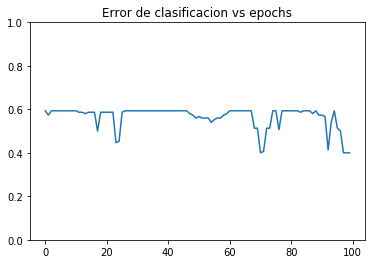

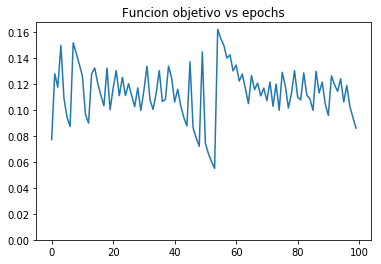

In [17]:
analizarCaso(X_train, y_onehot, sigmoid, d_sigmoid, softmax, d_softmax, loss_mse, d_loss_mse)

** Análisis**: En este caso pareciera que la función objetivo converge de manera oscilante hacia un valor mínimo, y de hecho la magnitud de las oscilaciones parece disminuir a medida que aumentan los epochs. Esto parece afectar el error de estimación que pareciera tener una muy leve tendencia a disminuir. Sin embargo, el aprendizaje también parece ser muy lento, lo que puede ser atribuible a la función de costo.   

** Caso 3: RELU y cross-entropy ** 

LR: 0.1
Epochs: 100
Tiempo de entrenamiento: 0.10970401763916016 (seg) 
Precision red entrenada: 33.3333333333 %


/anaconda3/envs/redes-neuronales/lib/python3.6/site-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in log
  
/anaconda3/envs/redes-neuronales/lib/python3.6/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in double_scalars
  
/anaconda3/envs/redes-neuronales/lib/python3.6/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in double_scalars
  if sys.path[0] == '':
/anaconda3/envs/redes-neuronales/lib/python3.6/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  if sys.path[0] == '':
/anaconda3/envs/redes-neuronales/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: overflow encountered in double_scalars
/anaconda3/envs/redes-neuronales/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in double_scalars
/anaconda3/envs/redes-neuronales/lib/python3.6/site-packages/ipykernel_launcher.

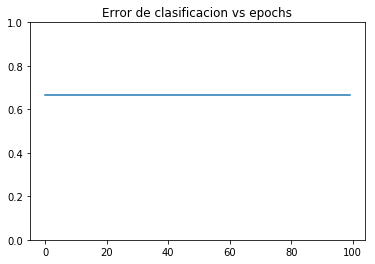

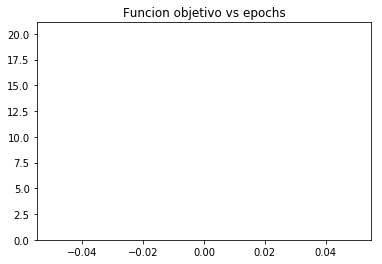

In [18]:
analizarCaso(X_train, y_onehot,
             relu, d_relu,
             softmax, d_softmax,
             loss_ce, d_loss_ce)

**Análisis**: En este caso, se presentan muchos errores de inestabilidad númerica, lo que resulta en valores nan o inf.
Esto de debe a la combinación de RELU con Cross-Entropy: por un lado RELU produce valores no acotados que pueden ser 
muy grandes y cross-entropy o su derivada hacen divisiones por estos grandes valores, lo que rapidamente lleva a 
underflow, overflow, o divisiones por cero.

Caso 4: sigmoid y cross-entropy

LR: 0.1
Epochs: 100
Tiempo de entrenamiento: 0.12714219093322754 (seg) 
Precision red entrenada: 63.3333333333 %
Matriz de confusion:
[[50  0  0]
 [ 4 45  1]
 [ 0 50  0]]


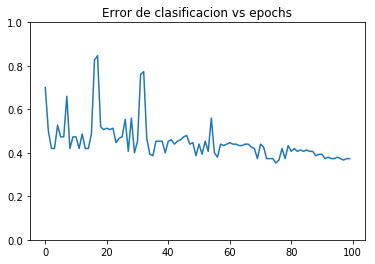

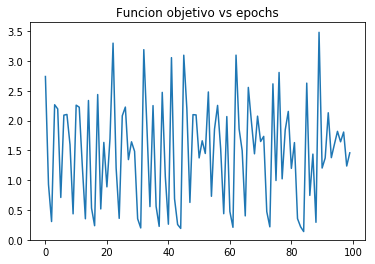

In [36]:
analizarCaso(X_train, y_onehot,
             sigmoid, d_sigmoid,
             softmax, d_softmax,
             loss_ce, d_loss_ce,_confusion=True)

** Análisis**: Este parece ser el mejor caso o mejor combinación para el entrenamiento. Si bien los valores dependen de los pesos inicializados al azar, en los mejores casos ha dado una precisión final superior al 60% (para 100 epochs), lo que mejora al aumentar los epochs. Al usar sigmoid en vez de RELU se soluciona el problema de inestabilidad numérica del caso anterior, y además el uso de cross-entropy propicia un aprendizaje mas rápido. 

**Matriz de confusión**
La matriz de confusión (filas: valor real)(columnas:valor esperado)
La diagonal representa los valores que fueron predecidos y que corresponden al valor esperado, los demás valores de la matriz corresponden a valores mal clasificados, indicando a que clase incorrecta fueron asignados.

# 2) Comparación con backpropagation de Keras

In [20]:
from keras.models import Sequential
from keras.layers.core import Dense
from keras.optimizers import SGD

In [21]:
## Función que permite ejecutar la implementación de keras, sacar tiempo y graficar.

def analizarCasoKeras(_X_train, _y_onehot, _act, _loss, _epochs = EPOCHS_KERAS):
    model = Sequential()
    model.add(Dense(32, input_dim = _X_train.shape[1], activation = _act))
    model.add(Dense(16, activation = _act))
    model.add(Dense( 3, activation = "softmax"))

    #Configurar optimizador
    model.compile(optimizer=SGD(lr=0.1),loss = _loss, metrics=["accuracy"])

    #Entrenamiento
    T_start = time.time()
    history = model.fit(_X_train, _y_onehot, epochs = _epochs, batch_size=1, verbose=0)
    T_end = time.time()
    T_time = T_end - T_start
    print ("Tiempo de entrenamiento: %s (seg) " % T_time)

    # Error de clasificacion vs epochs
    misacc = 1 - np.asarray(history.history['acc'])
    plt.plot(misacc)
    plt.ylim(ymin=0, ymax=1)
    plt.title("Error de clasificación vs epochs")
    plt.show()
    
    # Evolucion de la funcion objetivo vs epochs
    plt.plot(history.history['loss'])
    plt.ylim(ymin=0)
    plt.title("Función objetivo vs epochs")
    plt.show()    

### a) Modelo Keras para Caso 1: RELU y MSE

Tiempo de entrenamiento: 27.49435305595398 (seg) 


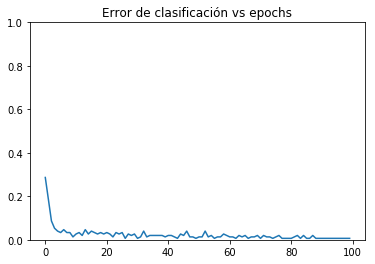

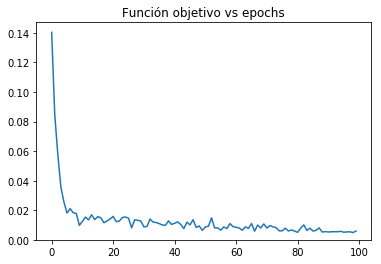

In [22]:
analizarCasoKeras(X_train, y_onehot, "relu", "mse")

### b) Modelo Keras para Caso 2: sigmoid y MSE

Tiempo de entrenamiento: 29.149749040603638 (seg) 


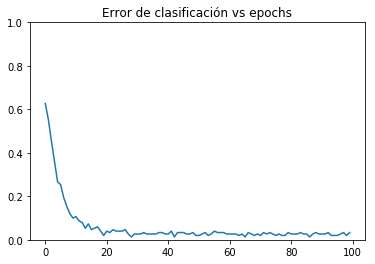

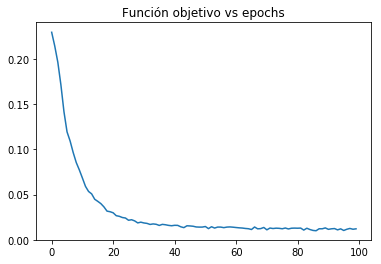

In [23]:
analizarCasoKeras(X_train, y_onehot, "sigmoid", "mse")

### c) Modelo Keras para Caso 3: RELU y cross-entropy

Tiempo de entrenamiento: 31.523850917816162 (seg) 


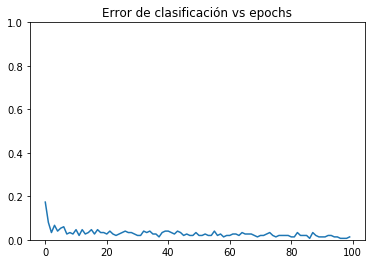

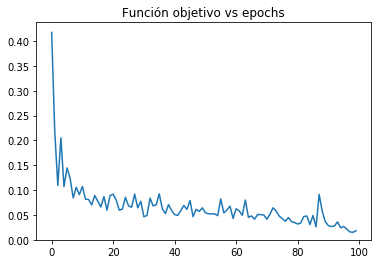

In [24]:
analizarCasoKeras(X_train, y_onehot, "relu", "categorical_crossentropy")

### d) Modelo Keras para Caso 4: sigmoid y cross-entropy

Tiempo de entrenamiento: 33.39975595474243 (seg) 


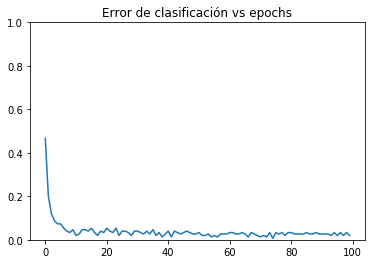

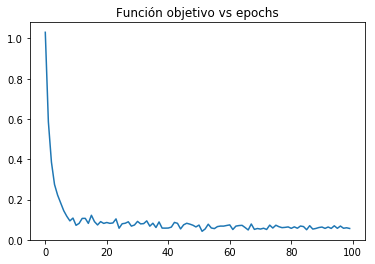

In [25]:
analizarCasoKeras(X_train, y_onehot, "sigmoid", "categorical_crossentropy")

** Análisis de resultados de implementación Keras. **

En los resultados obtenidos de la implementación de Keras, se logra visualizar de forma clara la convergencia, 
en el error de clasificación, disminuyendo el error a medida que aumentan las iteraciones. Entre los casos 1 y 2, 
se observa menor oscilación cuando se utiliza la función sigmoid, siendo que todo el resto de la configuración
es similar. Sin embargo pareciera ser que con relu alcanza valores mínimos más rápido (menos de 10 epochs) 
mientrás que con sigmoid se alcanzan valores similares después de los 20 epochs. 

Para los casos 3 y 4, también se observa menor oscilación cuando se utiliza la función sigmoid, 
sin embargo para el caso cuando se utiliza la función sigmoid, se llega en número menor de epochs a 
un mínimo, lo que es diferente al caso 1 y 2.

Con respecto a la función objetivo, para todos los casos se visualiza de forma clara la convergencia.
Para el caso de sigmoid el valor inicial es más grande en el eje y. Con sigmoid se aprencia menos ocilación.

El mejor resultado mezclando la comparación de los dos gráficos pareciera ser sigmoid/crossentropy.


## Análisis y conclusiones de convergencia, considerando implementación propia y Keras

Al comparar los resultados obtenidos en la implementación propia con respecto a los resultados de keras, se observa que  sí existen diferencias en la convergencia, tanto en error de clasificación como se función objetivo. 

En la implementación propia no se observa una convergencia a 0 como sí se logra visualizar en los gráficos de keras.  Esto se puede deber a los datos de inicialización y/o a la falta de sesgos en la implementación, lo que provoca una menor exactitud en los cálculos obtenidos.

Con respecto al tiempo de entrenamiento se puede observar que la implementación propia utiliza un tiempo mucho menor que el entrenamiento que Keras. Esto se puede deber a la que la implementación desarrollada en la tarea realiza menos cálculos de operaciones, lo que puede provovar una intestabilidad en los resultados del backwardpass.



# 3) Verificación numérica del gradiente


**Para evitar problemas de estabilidad numérica se utiliza activaciones sigmoid para las capas ocultas**

In [26]:
def verificarGradienteNumerico(epsilon):
    ## Dado un índice, compara el gradiente calculado por backpropagation
    ## vs el valor numérico para un epsilon dado.
        
    ## Matrices de pesos para verificación numérica
    _VW1 = np.random.random((SL1, SL2)).T
    _VW2 = np.random.random((SL2, SL3)).T
    _VW3 = np.random.random((SL3, SL4)).T
    
    indice = (np.random.choice(range(_VW1.shape[0])), np.random.choice(range(_VW1.shape[1])))
    print("Indice aleatorio escogido: %s" % (indice,))

    wij = _VW1[indice]

    ### Forward pass con pesos originales
    ypred_pre, _prez_4, _prea_3, _prez_3, _prea_2, _prez_2, _prea_1 = forwardpass(X_train[0],
                                                                                  _VW1, _VW2, _VW3,
                                                                                  sigmoid,
                                                                                  softmax)

    ## Actualizacion de valor en epsilon
    _VW1_eps = np.copy(_VW1)    
    _VW1_eps[indice] += epsilon

    ### Forward pass con peso modificado
    ypred_post, _, _, _, _, _, _ = forwardpass(X_train[0], _VW1_eps, _VW2, _VW3, sigmoid, softmax)

    ######################################################################################
    ####### Analisis perdida MSE

    ### Backward pass para obtener gradiente calculado con backpropagation
    ### Para funcion MSE
    delta_mse_VW1, _, _ = backwardpass(
                        y_onehot[0], ypred_pre,
                        loss_mse, d_loss_mse,
                        d_sigmoid, d_softmax,
                        ypred_pre, _prez_4, _prea_3, _prez_3, _prea_2, _prez_2, _prea_1,                    
                        _VW1, _VW2, _VW3,
                        SL1, SL2, SL3, SL4)

    ### Gradiente obtenido del backward pass
    delta_mse_wBP = delta_mse_VW1[indice]

    ### Gradiente obtenido de la verificacion numerica
    loss_mse_we = loss_mse(y_onehot[0], ypred_post)
    loss_mse_w  = loss_mse(y_onehot[0], ypred_pre)
    delta_mse_w = (loss_mse_we - loss_mse_w) / epsilon

    print("[MSE] Gradiente desde BP: %s" % delta_mse_wBP)
    print("[MSE] Gradiente numérico: %s" % delta_mse_w)

    ### Diferencia
    print("[MSE] La diferencia entre el gradiente de BP y el numerico es: %s" % (delta_mse_wBP - delta_mse_w))
    tolerancia = 1e-01
    print("[MSE] Los valores son cercanos con tolerancia %s: %s" %
          (tolerancia, np.isclose(delta_mse_w, delta_mse_wBP, rtol=tolerancia, atol=tolerancia)))

    ######################################################################################
    ####### Analisis perdida cross-entropy

    ### Backward pass para obtener gradiente calculado con backpropagation
    ### Para funcion cross-entropy
    delta_ce_VW1, _, _ = backwardpass(
                        y_onehot[0], ypred_pre,
                        loss_ce, d_loss_ce,
                        d_sigmoid, d_softmax,
                        ypred_pre, _prez_4, _prea_3, _prez_3, _prea_2, _prez_2, _prea_1,                    
                        _VW1, _VW2, _VW3,
                        SL1, SL2, SL3, SL4)

    ### Gradiente obtenido del backpward pass
    delta_ce_wBP = delta_ce_VW1[indice]

    ### Gradiente obtenido de la verificacion numerica
    loss_ce_we = loss_ce(y_onehot[0], ypred_post)
    loss_ce_w  = loss_ce(y_onehot[0], ypred_pre)
    delta_ce_w = (loss_ce_we - loss_ce_w) / epsilon

    print("[CE] Gradiente desde BP: %s" % delta_ce_wBP)
    print("[CE] Gradiente numérico: %s" % delta_ce_w)

    ### Diferencia
    print("[CE] La diferencia entre el gradiente de BP y el numerico es: %s" % (delta_ce_wBP - delta_ce_w))
    print("[CE] Los valores son cercanos con tolerancia %s: %s" %
          (tolerancia, np.isclose(delta_ce_w, delta_ce_wBP, rtol=tolerancia, atol=tolerancia)))

## a) Para un peso escogido aleatoriamente entre el input y la primera capa oculta

In [27]:
### Elegir posicion aleatoria en la matriz
epsilon = 1e-200 #e-10
verificarGradienteNumerico(epsilon)

Indice aleatorio escogido: (18, 3)
[MSE] Gradiente desde BP: 0.00143608178713
[MSE] Gradiente numérico: 0.0
[MSE] La diferencia entre el gradiente de BP y el numerico es: 0.00143608178713
[MSE] Los valores son cercanos con tolerancia 0.1: True
[CE] Gradiente desde BP: -0.0209291637079
[CE] Gradiente numérico: 0.0
[CE] La diferencia entre el gradiente de BP y el numerico es: -0.0209291637079
[CE] Los valores son cercanos con tolerancia 0.1: True


## b) Para otros dos pesos escogidos aleatoriamente


In [28]:
verificarGradienteNumerico(epsilon)
print("\n")
verificarGradienteNumerico(epsilon)

Indice aleatorio escogido: (8, 0)
[MSE] Gradiente desde BP: -0.000387306733487
[MSE] Gradiente numérico: 0.0
[MSE] La diferencia entre el gradiente de BP y el numerico es: -0.000387306733487
[MSE] Los valores son cercanos con tolerancia 0.1: True
[CE] Gradiente desde BP: -0.00799674530188
[CE] Gradiente numérico: 0.0
[CE] La diferencia entre el gradiente de BP y el numerico es: -0.00799674530188
[CE] Los valores son cercanos con tolerancia 0.1: True


Indice aleatorio escogido: (1, 0)
[MSE] Gradiente desde BP: -8.64591295675e-05
[MSE] Gradiente numérico: 0.0
[MSE] La diferencia entre el gradiente de BP y el numerico es: -8.64591295675e-05
[MSE] Los valores son cercanos con tolerancia 0.1: True
[CE] Gradiente desde BP: 0.239702609895
[CE] Gradiente numérico: 0.0
[CE] La diferencia entre el gradiente de BP y el numerico es: 0.239702609895
[CE] Los valores son cercanos con tolerancia 0.1: False


** Análisis de resultados y conclusiones **

Con respecto a los resultados obtenidos, se puede observar que el gradiente númerico y el de backpropagation coinciden con una tolerancia relativamente alta para la función MSE.
Sin embargo existe uana discrepancia mayor para cross-entropy, lo que indica falta de optimización o problemas númericos en la implementación del backward pass, o bien en la propia función cross entropy y su derivada.

# 4) Implementación momentum como variante


** Entrenamiento con momentum **

In [29]:
MU = 0.5

In [30]:
def train_momentum(
    _X_train, _y_train,
    _loss, _d_loss,
    _sL1, _sL2, _sL3, _sL4,
    _act, _act_out, _d_act, _d_act_out,
    _epochs,
    _verbose = False,
    _LR = 0.1,
    _mu = MU):    
    
    _W1 = np.random.random((_sL1, _sL2)).T + 0.01
    _W2 = np.random.random((_sL2, _sL3)).T + 0.01
    _W3 = np.random.random((_sL3, _sL4)).T + 0.01
    
    train_data = list(zip(_X_train, _y_train))
    random.shuffle(train_data)
    train_data = cycle(train_data)    
    loss_data = []
    epoch_data = []
    print("LR: %s" % _LR)
    print("Epochs: %s" % _epochs)
    
    ##################################################################
    ## Para implementacion de momentum
    ## Listas para almacenar los valores previos de V y de delta_W
    ## Asumiendo que V(0) = 0
    listV_3       = [0]
    listV_2       = [0]
    listV_1       = [0]
    listDelta_W3 = []
    listDelta_W2 = []
    listDelta_W1 = []
    
    def computeV(i, Vs, DWs):
        return _mu*Vs[i-1] - _LR*DWs[i-1]        
    
    # indice para V
    iv = 0
    ##################################################################
    
    print("MOMENTUM")
    
    for e in range(_epochs):
        
        epoch_data.append((_W1, _W2, _W3))
        
        x_example, y_example = next(train_data)
        
        a_4, z_4, a_3, z_3, a_2, z_2, a_1 = forwardpass(x_example,
                                                        _W1, _W2, _W3,                                                       
                                                        _act, _act_out)
        
        y_pred = a_4        
        loss = _loss(y_example, y_pred)        
        if(_verbose): #and e % 100 ==0):
            print("Epoch %s" % e)
            print("Loss: %s" % loss)
        
        loss_data.append(loss.item())    
        delta_W1, delta_W2, delta_W3 = backwardpass(y_example,        
                                          y_pred,
                                          _loss, _d_loss, _d_act, _d_act_out,
                                          a_4, z_4, a_3, z_3, a_2, z_2, a_1,                                          
                                          _W1, _W2, _W3,                                          
                                          _sL1, _sL2, _sL3, _sL4)
        
        ### Actualiza historial de deltas
        listDelta_W3.append(delta_W3)
        listDelta_W2.append(delta_W2)
        listDelta_W1.append(delta_W1)
        
        ## Agrega nuevos elementos calculados
        iv = iv + 1
        listV_3.append(computeV(iv, listV_3, listDelta_W3))
        listV_2.append(computeV(iv, listV_2, listDelta_W2))
        listV_1.append(computeV(iv, listV_1, listDelta_W1)) 
        
        ## Actualiza los pesos
        _W1 = _W1 + listV_1[iv]
        _W2 = _W2 + listV_2[iv]
        _W3 = _W3 + listV_3[iv]        
        
    return _W1, _W2, _W3, (range(_epochs), loss_data, epoch_data)

In [31]:
def analizarCasoMomentum(_X_train, _y_onehot,
                 _actfun , _d_actfun,
                 _actout , _d_actout,
                 _loss   , _d_loss  ,
                 _epochs = EPOCHS,
                 _LR = 0.1,
                 _verbose = False,
                 _training = train):
    
    analizarCaso(_X_train, _y_onehot,
                 _actfun , _d_actfun,
                 _actout , _d_actout,
                 _loss   , _d_loss  ,
                 _epochs = _epochs,
                 _LR = _LR,
                 _verbose = _verbose,
                 _training = train_momentum)

**Caso 1: RELU y MSE**

LR: 0.1
Epochs: 100
MOMENTUM
Tiempo de entrenamiento: 0.09430289268493652 (seg) 
Precision red entrenada: 34.6666666667 %


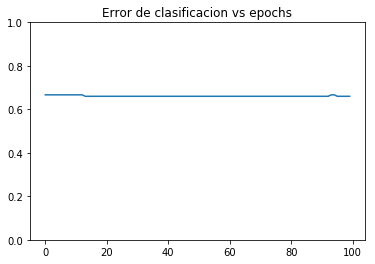

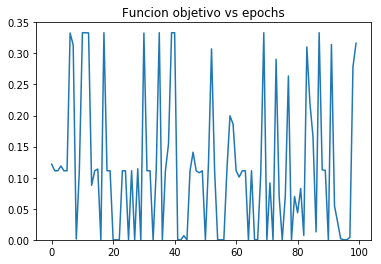

In [32]:
analizarCasoMomentum(X_train, y_onehot, relu, d_relu, softmax, d_softmax, loss_mse, d_loss_mse)

**Análisis**: Si bien es similar al caso 1 sin momentum, se puede observar que en algunas ejecuciones el error de precisión disminuye más que en la versión normal. Esto puede deberse al uso de momentum lo que permitio continuar en la dirección mas alla de un mínimo local. En todo caso, el efecto sería muy leve.

**Caso 2: sigmoid y MSE**

LR: 0.1
Epochs: 100
MOMENTUM
Tiempo de entrenamiento: 0.10358190536499023 (seg) 
Precision red entrenada: 8.0 %


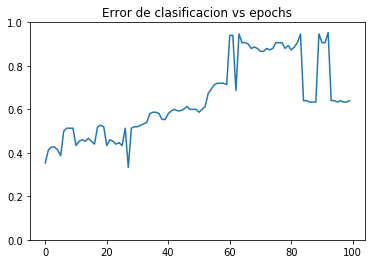

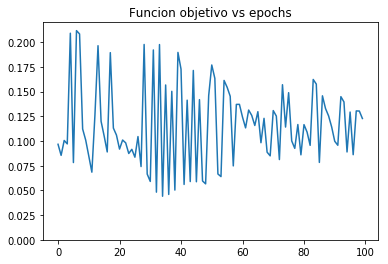

In [33]:
analizarCasoMomentum(X_train, y_onehot, sigmoid, d_sigmoid, softmax, d_softmax, loss_mse, d_loss_mse)

**Análisis**: en este caso se observa una notable mejora en la evolución  del error de precisión, aunque el error inicial es mayor que en el caso normal, se observa un rápido descenso atribuible al uso de momentum.

**Caso 3: RELU y cross-entropy**

LR: 0.1
Epochs: 100
MOMENTUM
Tiempo de entrenamiento: 0.10960268974304199 (seg) 
Precision red entrenada: 33.3333333333 %


/anaconda3/envs/redes-neuronales/lib/python3.6/site-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in log
  
/anaconda3/envs/redes-neuronales/lib/python3.6/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in double_scalars
  
/anaconda3/envs/redes-neuronales/lib/python3.6/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in double_scalars
  if sys.path[0] == '':
/anaconda3/envs/redes-neuronales/lib/python3.6/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  if sys.path[0] == '':
/anaconda3/envs/redes-neuronales/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: overflow encountered in double_scalars
/anaconda3/envs/redes-neuronales/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in double_scalars
/anaconda3/envs/redes-neuronales/lib/python3.6/site-packages/ipykernel_launcher.

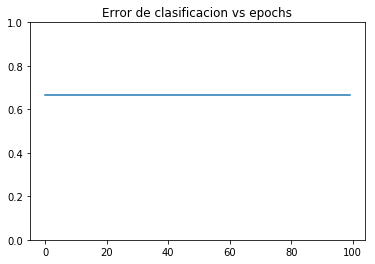

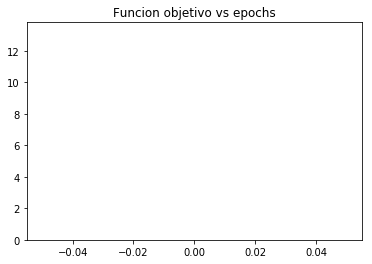

In [34]:
analizarCasoMomentum(X_train, y_onehot, relu, d_relu, softmax, d_softmax, loss_ce, d_loss_ce)

**Análisis**: debido de los problemas de inestabilidad numérica no fue posible probar momentum.

**Caso 4: sigmoid y cross-entropy**

LR: 0.1
Epochs: 100
MOMENTUM
Tiempo de entrenamiento: 0.1279737949371338 (seg) 
Precision red entrenada: 69.3333333333 %


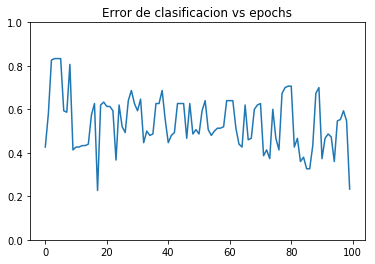

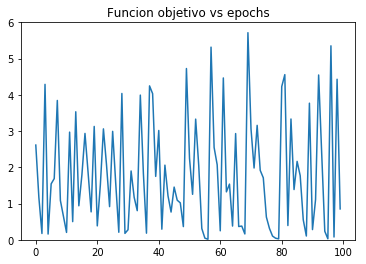

In [35]:
analizarCasoMomentum(X_train, y_onehot, sigmoid, d_sigmoid, softmax, d_softmax, loss_ce, d_loss_ce)

**Análisis**: Si bien el rango de valores de error se mantiene respecto al caso anterior, pareciera ser que el uso de momentum disminuye la oscilación dando periodos de mayor descenso continuado antes del siguiente salto.

**Comentario general momentum**: Si bien el efecto es poco apreciable para 100 epochs, considero que el momentum definitivamente ayuda a acelerar el aprendizaje de la red, pero en todo caso es necesario explorar  y configurar de manera adecuada el nuevo parámetro mu, que se uso sólo con valor fijo 0.5.

Principales referencias utilizadas:
- Neural Networks for Pattern Recongnition, Christopher M. Bishop
- Deep Learning Book, Ian Goodfellow and Yoshua Bengio and Aaron Courville
- http://peterroelants.github.io/posts/neural_network_implementation_part01/
    